<a href="https://colab.research.google.com/github/Kac1509/ZebrafishClassifier/blob/master/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import os

#Set if running locally or in Google Colaboratory
Colab = False
if Colab:
    Script_path = '/content/gdrive/My Drive/Colab Notebooks/Classifier/scripts'
    Base_path = '/content/gdrive/My Drive/Colab Notebooks/Classifier/'
    from google.colab import drive
    drive.mount('/content/gdrive')
else:
    Script_path = os.getcwd() + '/Classifier/scripts'
    Base_path = 'Classifier/'

#Add script folder to system path
sys.path.insert(0, Script_path)
print(sys.path)

['C:\\Users\\Kaleem\\EPFL\\Fall 2018\\Machine Learning\\Project_2\\Git\\ZebrafishClassifier/Classifier/scripts', '', 'C:\\Users\\Kaleem\\Anaconda3\\python36.zip', 'C:\\Users\\Kaleem\\Anaconda3\\DLLs', 'C:\\Users\\Kaleem\\Anaconda3\\lib', 'C:\\Users\\Kaleem\\Anaconda3', 'C:\\Users\\Kaleem\\AppData\\Roaming\\Python\\Python36\\site-packages', 'C:\\Users\\Kaleem\\Anaconda3\\lib\\site-packages', 'C:\\Users\\Kaleem\\Anaconda3\\lib\\site-packages\\Sphinx-1.5.6-py3.6.egg', 'C:\\Users\\Kaleem\\Anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\Kaleem\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\Kaleem\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Users\\Kaleem\\Anaconda3\\lib\\site-packages\\setuptools-27.2.0-py3.6.egg', 'C:\\Users\\Kaleem\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Kaleem\\AppData\\Roaming\\SPB_Data\\.ipython']


In [9]:
%load_ext autoreload
%autoreload 2

from build_model_RMSprop import *
from create_data_generators import *
from createFolders import *
from createSets import *
from GenotypeClass import *
from load_pre_trained_VGG16 import *
from load_pre_trained_Inception import *
from model_prediction import *
from plot_loss_acc import *
from predictClass import *
from saveFiles import *
from unzip_data import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
#Name of the data zipfile
Data_file = 'DataStraightened.zip'

#Set Paths
Zip_path = Base_path + Data_file
Extracted_path = Base_path + 'ExtractedData/'
Partitioned_path = Base_path + 'PartitionedData/'
Prediction_path = Base_path + 'Predictions/'
Validation_prediction_path = Base_path + 'Validation_Predictions/'


In [11]:
#Specify input parameters for the pre_trained model
shapeY = 150
shapeX = 750
color_channels = 3

# Loading pre-trained models

#VGG16 Model
local_weights_file_VGG16 = Base_path + 'weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model_VGG16, last_layer_output_VGG16 = load_pre_trained_VGG16(local_weights_file_VGG16, shapeY, shapeX, color_channels)

# Inception Model
#local_weights_file_Inception = Base_path + 'weights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
#pre_trained_model_Inception, last_layer_output_Inception = load_pre_trained_Inception(local_weights_file_Inception, shapeY, shapeX, color_channels)


In [12]:
#Clear Folders and create Prediction folder
deleteFiles(Extracted_path)
deleteFiles(Partitioned_path)
createFolder(Prediction_path)


In [13]:
#Extract Data
unzip_data(Zip_path, Extracted_path)

In [14]:

Genotypes = []
num_classes = len(glob.glob(Extracted_path+'*'))
for i in range(num_classes):
        #Retrieve directory for a given type
        Genotype_name = os.listdir(Extracted_path)[i]
        Genotypes.append(Genotype(Genotype_name))
print(num_classes)
createDirectories(num_classes,Extracted_path,Partitioned_path,Genotypes)


3


<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1359x150 at 0x1B2E52E1BE0>


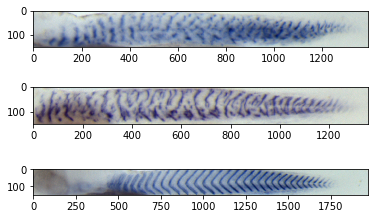

In [15]:
#Sample Image 
print(Genotypes[1].images[0])
plt.subplot(311)
plt.imshow(Genotypes[0].images[0])
plt.subplot(312)
plt.imshow(Genotypes[1].images[0])
plt.subplot(313)
plt.imshow(Genotypes[2].images[0])

In [16]:
#Partition data into training and test set
#If fixed set to true, all training and test sets have the same size for all classes 
createTrain_Test(Genotypes,0.5, fixed = True)

31
76
33


In [17]:
#Save partitions to respective folders
saveFiles(Genotypes)

In [18]:
# Creating training and validation data generators from separated data
# Transformations are for training generator only

train_generator, validation_generator = create_data_generators(
    Partitioned_path,
    shapeY, shapeX, 
    train_batch_size=12, 
    validation_batch_size=15,
    class_mode='categorical')#,
    #rotation_range=30,
    #width_shift_range=0.3,
    #height_shift_range=0.3,
    #shear_range=0.3,
    #zoom_range=0.3)

Found 48 images belonging to 3 classes.
Found 45 images belonging to 3 classes.


In [22]:
# Building model
%reload_ext autoreload
learning_rate = 0.00001
hidden_units_num = 1024
dropout_rate = 0.5 #"rate=0.1" would drop out 10% of input units.
model = build_model_RMSprop(pre_trained_model_VGG16, last_layer_output_VGG16, 
                            Dropout = False,
                            dropout_rate = dropout_rate, 
                            learning_rate = learning_rate ,
                            hidden_units_num = hidden_units_num,
                            num_classes=num_classes,
                            activation = 'softmax')

In [ ]:
# Training model

history = model.fit_generator(
      train_generator,
      steps_per_epoch=4,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=3,
      verbose=2)

Epoch 1/30


In [ ]:
#Predict Model based on validation set

model_prediction(
    model, 
    Genotypes,
    Validation_prediction_path,
    shapeY, shapeX, 
    class_mode = 'categorical' # If the content of class0_test_path and class1_test_path should be refreshed
    )

In [ ]:
#Predict Model based on Images placed in Prediction Folder
float_formatter = lambda x: "%.4f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

predictionFiles, predictions = predictClass(model,Prediction_path, shapeY, shapeX, class_mode='categorical')
#print(predictions)
for i in range(len(predictions)):
    print(predictionFiles.filenames[i])
    print(predictions[i])

In [ ]:
#Plot training and validation accuracy per epoch

plot_loss_acc(history)

In [ ]:
import csv
ModelType = 'Prediction_Model_1_Option1_' 
time = f"{datetime.datetime.now():%Y-%m-%d_%H%M}"
csvName = ModelType + time + '.csv'
PredictionCSV = Base_path + csvName
with open(PredictionCSV, 'w') as csvfile:
    fieldnames = ['Filename', 'WT', 'FSS', 'HH']
    writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames,lineterminator = '\n')
    writer.writeheader()
    for i in range(len(predictions)):
        writer.writerow({'Filename':str(predictionFiles.filenames[i]),'WT':float(format(predictions[i][0], '.4f')),'FSS':float(format(predictions[i][1], '.4f')),'HH':float(format(predictions[i][2], '.4f'))})
    Model_parameters = model.optimizer,", Learning Rate:", learning_rate, ", Hidden_Units:", hidden_units_num, "Input_size:", model.inputs
    writer.writerow({'Filename':"Model",'WT':str(Model_parameters)})
    